In [135]:
%reset -f

In [136]:
import numpy as np
from scipy.io.wavfile import read, write
import matplotlib.pyplot as plt

In [137]:
from scipy.optimize import minimize

In [138]:
from time import time

In [139]:
start = time()

In [140]:
input_name = 'acguitar'
desired_name = 'actoel'
save_name = 'volterraactoel'

In [141]:
pitch = 391.985472782207
order_harmonic = 9
freq_res = 5.0

In [142]:
max_order_nonlinearity = 8
order_nonlinearity = np.arange(1,max_order_nonlinearity+1,1)
train_size = 1000
epochs = 1
validation_size = 1000
reg_parambeg = -8
reg_paramend = 2
reg_param = np.logspace(reg_parambeg,reg_paramend,reg_paramend-reg_parambeg+1)
slice_width = 1

In [143]:
def harm_env_save(x,harmonic_no,order_nonlinearity,fs,freq_res,pitch,filename):
    L = len(x)
    
    t = np.arange(0,L/fs,1/fs)
    
    window1 = int(np.ceil(10*fs/pitch))
    window2 = int(np.ceil(3*fs/pitch))
    
    Env = np.zeros((L-window1+1,order_nonlinearity),dtype=complex)
    
    M = L-window1+1
    
    mva1 = (1/window1)*np.ones(window1)
    mva2 = (1/window2)*np.ones(window2)
    
    t1 = t[0:L-window1+1]   
    
    for i in range(order_nonlinearity):
        
        temp = np.exp(-2*np.pi*1.j*harmonic_no*pitch*t)*(x**(i+1))
        temp = (np.convolve(mva1,temp))[window1-1:L]
        
        Env_amp = np.abs(temp)
        Env_phi = np.unwrap(np.angle(temp))
        
        Env_amp = np.convolve(mva2,Env_amp)[window2-1:M+window2-1]
        Env_phi = np.convolve(mva2,Env_phi)[window2-1:M+window2-1]
        Env[:,i] = Env_amp*np.exp(1.j*Env_phi)
    
    np.savez(filename+'.npz',Env)
    del temp, Env_phi, Env_amp

In [144]:
fs, x = read(input_name+'.wav')
max_ = np.max(np.abs(x))
x = (x/max_).astype(np.float32)

In [145]:
# Find pitch, maxorder,envelopes,refine etc
for i in range(1,order_harmonic+1):
    filename = input_name+'_'+str(i)
    harm_env_save(x,i,max_order_nonlinearity,fs,freq_res,pitch,filename)

In [146]:
def func_grad(param,X,Y,reg_param):
    w_r = param[0:len(X[0])]
    w_i = param[len(X[0]):2*len(X[0])]
    w = w_r+1.j*w_i
    
    phi = param[2*len(X[0]):]
    
    X_dag = np.conj(X.T)
    phase_array = np.exp(1.j*phi)
    grad_w = (X_dag@X+reg_param*np.eye(len(X_dag)))@w-\
    X_dag@(np.conj(phase_array)*Y)
    grad_w_r = np.real(grad_w)
    grad_w_i = np.imag(grad_w)
    grad_w = np.concatenate((grad_w_r,grad_w_i))
    
    grad_phi = np.imag(np.conj(Y)*phase_array*(X@w))
    
    func = (np.linalg.norm(Y-phase_array*(X@w))**2)/(np.sum(Y**2))
    grad = np.concatenate((grad_w,grad_phi))
    return func, grad

In [147]:
def train_wt(order_nonlinearity,reg_param,slice_width,train_size,epochs,validation_size,input_name,desired_name):
    '''
    Run leastsquares for epochs in epochs.
    Average and return weights and squared error for validation data
    '''
    #Import target location array
    data = np.load(desired_name+'.npz')
    lst = data.files
    Env_desired = np.abs(data[lst[0]])
    
    L = len(Env_desired)
    order_harmonic = len(Env_desired[0])
    
    shuffle_index = np.random.permutation(L//slice_width)
    rand_index_train = slice_width*shuffle_index[0:epochs*train_size]
    rand_index_validation = slice_width*shuffle_index[epochs*train_size:validation_size+epochs*train_size]
    
    w = np.zeros((epochs,order_nonlinearity,order_harmonic),dtype=complex)
    Y_validation_pred = np.zeros((validation_size,order_harmonic),dtype=complex)
    
    for l in range(order_harmonic):
        #Import file for the relevant harmonic
        data = np.load(input_name+'_'+str(l+1)+'.npz')
        lst = data.files
        Env_harmonic = data[lst[0]]
        Env_desired_harmonic = Env_desired[:,l]
        
        for m in range(epochs):
            Y = Env_desired_harmonic[rand_index_train[m*train_size:(m+1)*train_size]]
            X = Env_harmonic[rand_index_train[m*train_size:(m+1)*train_size]]
            X = X[:,0:order_nonlinearity]
            
            param_init = np.random.randn(2*order_nonlinearity+len(Y))
            
            opts = {'maxiter':10000}
            res = minimize(func_grad,param_init,args=(X,Y,reg_param),jac=True,method='L-BFGS-B',tol=0.5*1e-3,options=opts)
            w_temp = res.x[0:order_nonlinearity]+1.j*res.x[order_nonlinearity:2*order_nonlinearity]
            w[m,:,l] = np.exp(-1.j*np.angle(w_temp[0]))*w_temp
            
        w_mean_harmonic = np.mean(w[:,:,l],axis=0)
        X_validation = (Env_harmonic[rand_index_validation])[:,0:order_nonlinearity]
        Y_validation_pred[:,l] = X_validation@(w_mean_harmonic)
    
    w_mean = np.mean(w,axis=0)
    
    Y_validation = Env_desired[rand_index_validation]
    sqerr = np.mean(np.abs(Y_validation-np.abs(Y_validation_pred))**2)/(np.mean(Y_validation)**2)
    
    return w_mean, sqerr

In [148]:
'''
def func_grad(param,X,Y,reg_param):
    w_r = param[0:len(X[0])]
    w_i = param[len(X[0]):2*len(X[0])]
    w = w_r+1.j*w_i
    
    phi = param[2*len(X[0]):]
    
    X_dag = np.conj(X.T)
    phase_array = np.exp(1.j*phi)
    grad_w = (X_dag@X+reg_param*np.eye(len(X_dag)))@w-\
    X_dag@(np.conj(phase_array)*Y)
    grad_w_r = np.real(grad_w)
    grad_w_i = np.imag(grad_w)
    grad_w = np.concatenate((grad_w_r,grad_w_i))
    
    grad_phi = np.imag(np.conj(Y)*phase_array*(X@w))
    
    func = (np.linalg.norm(Y-phase_array*(X@w))**2)/(np.sum(Y**2))
    grad = np.concatenate((grad_w,grad_phi))
    return func, grad
'''

'\ndef func_grad(param,X,Y,reg_param):\n    w_r = param[0:len(X[0])]\n    w_i = param[len(X[0]):2*len(X[0])]\n    w = w_r+1.j*w_i\n    \n    phi = param[2*len(X[0]):]\n    \n    X_dag = np.conj(X.T)\n    phase_array = np.exp(1.j*phi)\n    grad_w = (X_dag@X+reg_param*np.eye(len(X_dag)))@w-    X_dag@(np.conj(phase_array)*Y)\n    grad_w_r = np.real(grad_w)\n    grad_w_i = np.imag(grad_w)\n    grad_w = np.concatenate((grad_w_r,grad_w_i))\n    \n    grad_phi = np.imag(np.conj(Y)*phase_array*(X@w))\n    \n    func = (np.linalg.norm(Y-phase_array*(X@w))**2)/(np.sum(Y**2))\n    grad = np.concatenate((grad_w,grad_phi))\n    return func, grad\n'

In [149]:
'''order_ = 9
data = np.load(desired_name+'.npz')
lst = data.files
Env_desired = np.abs(data[lst[0]])
    
L = len(Env_desired)
order_harmonic = len(Env_desired[0])
    
shuffle_index = np.random.permutation(L//slice_width)
rand_index_train = slice_width*shuffle_index[0:train_size]
rand_index_validation = slice_width*shuffle_index[train_size:validation_size+train_size]

data = np.load(input_name+'_'+str(1)+'.npz')
lst = data.files
Env_harmonic = data[lst[0]]
Env_desired_harmonic = Env_desired[:,0]
plt.plot(Env_desired_harmonic,np.abs(Env_harmonic[:,1]),'rx')
plt.show()

Y = Env_desired_harmonic[rand_index_train[0*train_size:(1)*train_size]]
X = Env_harmonic[rand_index_train[0*train_size:(1)*train_size]]
X = X[:,0:order_]
X_dag = np.conj(X.T)
Y_val = Env_desired_harmonic[rand_index_validation]
'''

"order_ = 9\ndata = np.load(desired_name+'.npz')\nlst = data.files\nEnv_desired = np.abs(data[lst[0]])\n    \nL = len(Env_desired)\norder_harmonic = len(Env_desired[0])\n    \nshuffle_index = np.random.permutation(L//slice_width)\nrand_index_train = slice_width*shuffle_index[0:train_size]\nrand_index_validation = slice_width*shuffle_index[train_size:validation_size+train_size]\n\ndata = np.load(input_name+'_'+str(1)+'.npz')\nlst = data.files\nEnv_harmonic = data[lst[0]]\nEnv_desired_harmonic = Env_desired[:,0]\nplt.plot(Env_desired_harmonic,np.abs(Env_harmonic[:,1]),'rx')\nplt.show()\n\nY = Env_desired_harmonic[rand_index_train[0*train_size:(1)*train_size]]\nX = Env_harmonic[rand_index_train[0*train_size:(1)*train_size]]\nX = X[:,0:order_]\nX_dag = np.conj(X.T)\nY_val = Env_desired_harmonic[rand_index_validation]\n"

In [150]:
'''for l in range(order_harmonic):
    w_init1 = np.random.randn(order_)
    w_init_r = np.real(w_init1)
    w_init_i = np.imag(w_init1)
    w_init = np.concatenate((w_init_r,w_init_i))

phase_init = np.random.randn(len(Y))
step_size = 1.
param_init = np.concatenate((w_init,phase_init))
param = param_init.copy()

f = []
gr = []
for i in range(10000):
    func, grad = func_grad(param,np.abs(X),Y,0.)
    param = param-step_size*grad
    f.append(func)
    gr.append(np.linalg.norm(grad)/len(grad))
plt.plot(f)
plt.show()
plt.plot(gr)
plt.show()
'''

'for l in range(order_harmonic):\n    w_init1 = np.random.randn(order_)\n    w_init_r = np.real(w_init1)\n    w_init_i = np.imag(w_init1)\n    w_init = np.concatenate((w_init_r,w_init_i))\n\nphase_init = np.random.randn(len(Y))\nstep_size = 1.\nparam_init = np.concatenate((w_init,phase_init))\nparam = param_init.copy()\n\nf = []\ngr = []\nfor i in range(10000):\n    func, grad = func_grad(param,np.abs(X),Y,0.)\n    param = param-step_size*grad\n    f.append(func)\n    gr.append(np.linalg.norm(grad)/len(grad))\nplt.plot(f)\nplt.show()\nplt.plot(gr)\nplt.show()\n'

In [151]:
def get_hyperparamters(order_nonlinearity,reg_param,slice_width,train_size,epochs,validation_size,input_name,desired_name):
    sqerr = np.zeros((len(order_nonlinearity),len(reg_param)))
    for l in range(len(order_nonlinearity)):
        for m in range(len(reg_param)):
            wt, sqerr[l,m] = train_wt(order_nonlinearity[l],reg_param[m],slice_width,train_size,epochs,validation_size,input_name,desired_name)
            del wt
    ind = np.unravel_index(np.argmin(sqerr, axis=None), sqerr.shape)
    optim_order = order_nonlinearity[ind[0]]
    optim_reg_param = reg_param[ind[1]]
    print('=====================================')
    print('Optimal order is')
    print(optim_order)
    print('=====================================')
    print('Optimal reg param is')
    print(optim_reg_param)
    print('=====================================')
    print('Squared error is')
    print(sqerr[ind[0],ind[1]])
    print('===========================')
    print(sqerr)
    wt, sqerrtemp = train_wt(optim_order,optim_reg_param,slice_width,train_size,epochs,validation_size,input_name,desired_name)
    
    return wt,optim_order,optim_reg_param

In [152]:
'''data = np.load(desired_name+'.npz')
lst = data.files
Env_desired = np.abs(data[lst[0]])
    
L = len(Env_desired)
order_harmonic = len(Env_desired[0])
    
shuffle_index = np.random.permutation(L//slice_width)
rand_index_train = slice_width*shuffle_index[0:train_size]
rand_index_validation = slice_width*shuffle_index[train_size:validation_size+train_size]

data = np.load(input_name+'_'+str(1)+'.npz')
lst = data.files
Env_harmonic = data[lst[0]]
Env_desired_harmonic = Env_desired[:,0]

Y = Env_desired_harmonic[rand_index_train[0*train_size:(1)*train_size]]
X = Env_harmonic[rand_index_train[0*train_size:(1)*train_size]]
X = X[:,0:order_]
X_dag = np.conj(X.T)
Y_val = Env_desired_harmonic[rand_index_validation]
'''

"data = np.load(desired_name+'.npz')\nlst = data.files\nEnv_desired = np.abs(data[lst[0]])\n    \nL = len(Env_desired)\norder_harmonic = len(Env_desired[0])\n    \nshuffle_index = np.random.permutation(L//slice_width)\nrand_index_train = slice_width*shuffle_index[0:train_size]\nrand_index_validation = slice_width*shuffle_index[train_size:validation_size+train_size]\n\ndata = np.load(input_name+'_'+str(1)+'.npz')\nlst = data.files\nEnv_harmonic = data[lst[0]]\nEnv_desired_harmonic = Env_desired[:,0]\n\nY = Env_desired_harmonic[rand_index_train[0*train_size:(1)*train_size]]\nX = Env_harmonic[rand_index_train[0*train_size:(1)*train_size]]\nX = X[:,0:order_]\nX_dag = np.conj(X.T)\nY_val = Env_desired_harmonic[rand_index_validation]\n"

In [153]:
w,optim_order,optim_reg_param = get_hyperparamters(order_nonlinearity,reg_param,slice_width,train_size,epochs,validation_size,input_name,desired_name)

Optimal order is
5
Optimal reg param is
1e-07
Squared error is
0.45728904502699813
[[0.74742401 0.65005414 1.33788795 0.58896921 0.65527402 0.7137069
  0.9771161  1.12737754 1.60495358 1.80024153 2.02334787]
 [0.95350663 1.12223379 1.13536108 0.66096256 0.65257795 0.6231448
  1.03601924 1.71107502 2.13719095 2.15522297 1.78183487]
 [0.64023464 0.57963673 0.55449348 0.63318309 0.59808297 0.6016977
  0.61457625 1.61042242 2.03467413 2.15100533 1.78467514]
 [0.59541832 0.58610464 0.48402613 1.04151055 0.59964309 0.57073156
  0.61295501 1.84980464 2.0166953  1.93933344 1.29724979]
 [0.51071143 0.45728905 0.54673969 0.56833788 0.59112569 0.50610834
  0.65931878 1.67500495 1.9978123  2.12819545 1.33402131]
 [0.56571054 0.55731991 0.50477829 0.5522642  0.56577211 0.63829464
  0.64457218 1.6936784  2.04258411 2.22914234 1.26593488]
 [0.51397064 0.62239339 0.5802957  0.54885783 0.51671669 0.58067982
  0.77439071 1.23194721 2.10048177 1.96949918 1.31585557]
 [0.59294467 0.49305778 0.50384895 0.4

In [154]:
w

array([[ 2.97610762e+00+4.44089210e-16j,  2.65816451e-02-3.46944695e-18j,
         9.14754181e-01+0.00000000e+00j,  1.00357201e-01+0.00000000e+00j,
         1.42168239e+00+0.00000000e+00j,  9.11180157e-02+0.00000000e+00j,
         3.18689483e+00+0.00000000e+00j,  3.90924597e-02+3.46944695e-18j,
         3.17409353e-01-2.77555756e-17j],
       [ 5.62972164e-02-1.23111014e+00j,  5.17853081e-03+1.27859877e-01j,
         3.21010572e-01+5.74830147e+00j,  9.60823622e-02-6.58141336e-01j,
         5.80000960e+00+4.14886370e+00j,  3.52703530e-01+3.78244071e-01j,
         5.54609795e+00+5.20397390e+00j,  2.18420300e-01-2.01088453e-01j,
         9.59140768e-02+4.28171415e-03j],
       [-1.26827929e+00+1.22753768e-01j, -1.99066028e-01-2.06643493e-01j,
        -6.32289416e+00+4.16885243e+00j, -5.95197696e-01-7.94044118e-01j,
        -2.25410377e+01-8.09920056e+00j, -7.97446232e-01-1.12293197e-01j,
        -9.49526645e-01+2.15354816e-01j, -3.56350599e-01+3.92861098e-01j,
        -7.02417598e-01-3.36

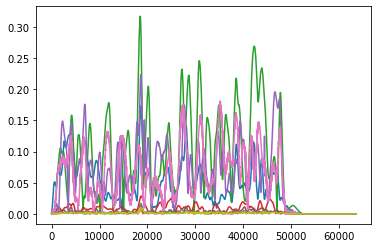

0.007259786658107536


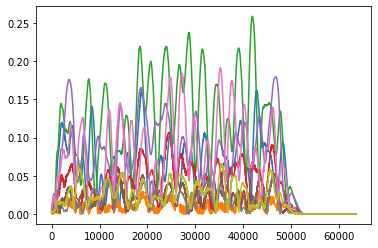

In [155]:
data = np.load(input_name+'_'+str(1)+'.npz')
lst = data.files
Env_harmonic = data[lst[0]]
L = len(Env_harmonic)
    
final_env = np.zeros((L,order_harmonic))
for i in range(order_harmonic):
    data = np.load(input_name+'_'+str(i+1)+'.npz')
    lst = data.files
    Env_harmonic = data[lst[0]]
    final_env[:,i] = np.abs(Env_harmonic[:,0:optim_order]@w[:,i])
    plt.plot(final_env[:,i])
plt.show()
data = np.load(desired_name+'.npz')
lst = data.files
Env_desired = data[lst[0]]

print(np.mean(np.abs(Env_desired-final_env[0:len(Env_desired)])**2))
for i in range(order_harmonic):
    plt.plot(np.abs(Env_desired[:,i]))
plt.show()

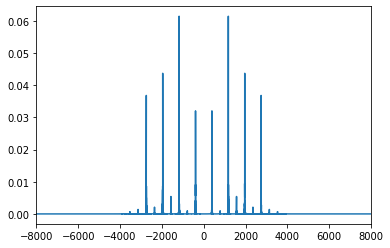

In [156]:
n = np.arange(1,len(final_env[0])+1,1)
t = np.arange(0,len(final_env)/fs,1/fs)
T, N = np.meshgrid(t,n)
Mult = np.sin(2*np.pi*N*pitch*T)
del n,N,T
out = final_env.T*Mult
del Mult
out = np.sum(out,axis=0)
m = np.max(np.abs(out))
sigf32 = (out/m).astype(np.float32)
write(save_name+'.wav',fs,sigf32)

f = np.linspace(-fs/2,fs/2,len(t)+1)[:-1]
S = (1/len(t))*np.fft.fftshift(np.fft.fft(sigf32))
plt.plot(f,np.abs(S))
plt.xlim([-8000,8000])
plt.show()

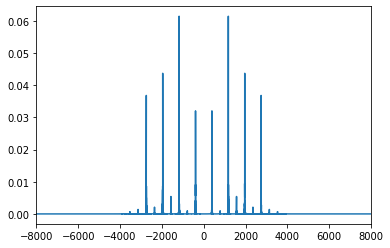

In [157]:
plt.plot(f,np.abs(S))
plt.xlim([-8000,8000])
plt.show()

In [158]:
end = time()
print(end-start)

73.42502570152283
